#Introduzione e Obiettivo del Progetto
 L'obiettivo di questo progetto è sviluppare una strategia di investimento sistematica e avanzata, con lo scopo di costruire un portafoglio ottimizzato a partire dall'universo di azioni del NASDAQ-100.
Il problema centrale dell'asset management è duplice: non solo dobbiamo decidere *quali* azioni comprare, ma anche *quanto* capitale allocare su ciascuna di esse. Affrontare la prima domanda, quella della selezione, su un paniere di 100 titoli, è un problema di ottimizzazione combinatoria di vasta scala, con un numero di possibili portafogli che supera i trilioni.(letteralmente 100^10 possibili combinazioni)
Per risolvere questa sfida, adotteremo un approccio ibrido e innovativo a due fasi.
**Perché questo approccio?**
La nostra filosofia è usare lo strumento giusto per il lavoro giusto.
Per il problema della selezione, che è vasto e combinatorio, sfrutteremo i principi del Quantum Annealing (attraverso i simulatori di D-Wave). Questa tecnologia è progettata specificamente per esplorare in modo efficiente spazi di soluzioni enormi e trovare candidati promettenti.
Per il problema dell'allocazione, una volta ridotto l'universo a un piccolo numero di candidati, useremo un ottimizzatore classico e di precisione (scipy.optimize), perfetto per calcolare le ponderazioni matematicamente ottimali.
*** L'obiettivo finale è verificare se questa strategia ibrida sia in grado di generare un "alpha", ovvero un extra-rendimento corretto per il rischio, rispetto a una strategia passiva che investe sull'intero indice NASDAQ-100.***

In [ ]:
# Packages
import dwave.system
from dwave.cloud import Client
from dimod import BinaryQuadraticModel
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import yfinance as yf
import datetime as dt
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

In [2]:
# Cella 2 (Versione NASDAQ-100 con lista statica)

# --- 1. USARE UNA LISTA STATICA DEI TICKER DEL NASDAQ-100 ---

tickers = [
    'MSFT', 'AAPL', 'NVDA', 'AMZN', 'META', 'AVGO', 'GOOGL', 'TSLA', 'GOOG',
    'COST', 'AMD', 'NFLX', 'PEP', 'ADBE', 'LIN', 'CSCO', 'TMUS', 'INTC',
    'CMCSA', 'QCOM', 'INTU', 'AMGN', 'TXN', 'HON', 'AMAT', 'BKNG', 'LRCX',
    'ISRG', 'ADI', 'VRTX', 'REGN', 'SBUX', 'ADP', 'MDLZ', 'PANW', 'MU',
    'PYPL', 'SNPS', 'KLAC', 'CDNS', 'ASML', 'GILD', 'MELI', 'CRWD', 'CSX',
    'MAR', 'CTAS', 'ORLY', 'PCAR', 'MRNA', 'ABNB', 'WDAY', 'ROP', 'FTNT',
    'CEG', 'PAYX', 'FAST', 'DXCM', 'BIIB', 'KDP', 'AEP', 'DDOG', 'EXC',
    'MNST', 'CPRT', 'IDXX', 'LULU', 'TEAM', 'BKR', 'MCHP', 'AZN', 'EA',
    'MRVL', 'CTSH', 'KHC', 'GEHC', 'ROST', 'SGEN', 'WBA', 'ODFL', 'ON',
    'CSGP', 'XEL', 'FANG', 'DLTR', 'ANSS', 'TTD', 'PCG', 'MDB', 'ILMN',
    'ZS', 'WBD', 'SIRI', 'ALGN', 'ENPH', 'JD', 'LCID'
]



# --- 2. DEFINIRE IL PERIODO E SCARICARE I DATI ---
end_date = datetime.now()
start_date = datetime(end_date.year - 15, end_date.month, end_date.day)

print(f"Download dei dati storici per {len(tickers)} titoli in corso...")
prices_df = yf.download(tickers, start=start_date, end=end_date)['Close']

# --- 3. PULIZIA DEI DATI ---
# Rimuoviamo le colonne (titoli) che hanno troppi valori mancanti (es. IPO recenti).
# Manteniamo solo i titoli con almeno il 90% dei dati disponibili per il periodo.
prices_df.dropna(axis=1, thresh=len(prices_df) * 0.9, inplace=True)
# Rimuoviamo le righe che hanno ancora qualche valore mancante (giorni festivi, etc.).
prices_df.dropna(axis=0, how='any', inplace=True)

# Aggiorniamo la nostra lista di ticker finali
tickers = prices_df.columns.tolist()

print("\nDownload e pulizia completati!")
print(f"Dataset finale composto da {len(tickers)} titoli e {len(prices_df)} giorni di dati.")
print("Ecco un'anteprima:")
print(prices_df.head())

Download dei dati storici per 97 titoli in corso...


C:\Users\danie\AppData\Local\Temp\ipykernel_8560\2777333386.py:26: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices_df = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  97 of 97 completed

1 Failed download:
['SGEN']: YFTzMissingError('possibly delisted; no timezone found')



Download e pulizia completati!
Dataset finale composto da 77 titoli e 3770 giorni di dati.
Ecco un'anteprima:
Ticker          AAPL       ADBE        ADI        ADP        AEP       ALGN  \
Date                                                                          
2010-07-22  7.784635  28.580000  21.634630  25.610300  20.129671  14.830000   
2010-07-23  7.812284  29.230000  21.811327  25.875906  20.135298  17.120001   
2010-07-26  7.792453  29.170000  22.051634  25.974741  20.343391  18.350000   
2010-07-27  7.936712  29.219999  21.938547  25.968569  20.602119  18.049999   
2010-07-28  7.842940  28.690001  21.422592  26.005629  20.590870  17.370001   

Ticker          AMAT   AMD       AMGN    AMZN  ...      SBUX      SIRI  \
Date                                           ...                       
2010-07-22  9.747108  7.61  36.863747  6.0035  ...  9.560889  7.839187   
2010-07-23  9.794086  7.82  36.476486  5.9435  ...  9.648328  8.086744   
2010-07-26  9.833225  8.07  37.112690  

# CALCOLO METRICHE FINANZIARIE
Cosa abbiamo fatto:
Dai dati grezzi dei prezzi, abbiamo calcolato i rendimenti giornalieri. Da questi, abbiamo derivato due matrici di input essenziali per i nostri modelli:
mu (μ): Il vettore dei rendimenti medi annui attesi per ogni titolo.
Sigma (Σ): La matrice di covarianza annuale, che descrive sia il rischio individuale di ogni azione (la sua volatilità) sia come le azioni si muovono l'una rispetto all'altra (le loro correlazioni).
Infine, abbiamo visualizzato la matrice Sigma usando una heatmap (mappa di calore).
Perché lo abbiamo fatto?
Lo scopo era trasformare dati grezzi (i prezzi) in informazioni quantitative e interpretabili. Il vettore mu rappresenta il nostro obiettivo di "ricompensa" (alto rendimento), mentre la matrice Sigma rappresenta il nostro obiettivo di "rischio" da gestire. La heatmap ci ha fornito un'intuizione visiva immediata su quali fossero i titoli più volatili e, soprattutto, quali fossero le coppie di titoli più o meno correlate, un concetto chiave per la diversificazione.
Tutti dati che la QUBO function avrà in pasto per definire la top10 stocks, più precisamente la qubo function tenderà a massimizzare la sharpe ratio cercando asset non correlati.

In [3]:
# Cella 3: Calcolo delle Metriche Finanziarie

# 1. CALCOLARE I RENDIMENTI GIORNALIERI
# Il rendimento è la variazione percentuale del prezzo rispetto al giorno precedente.
# Il metodo .pct_change() lo fa automaticamente per noi.
# .dropna() rimuove la prima riga che sarà vuota (non c'è un rendimento per il primo giorno).
returns_df = prices_df.pct_change().dropna()

print("--- Rendimenti Giornalieri Calcolati ---")
print(returns_df.round(2).head())

# 2. CALCOLARE IL RENDIMENTO MEDIO ANNUO (mu) E LA MATRICE DI COVARIANZA ANNUALE (Sigma)
# Usiamo 252 come numero standard di giorni di trading in un anno per annualizzare le nostre metriche.
trading_days = 252

# Rendimento medio atteso (vettore mu)
# Calcoliamo la media dei rendimenti giornalieri e la moltiplichiamo per 252.
mu = returns_df.mean() * trading_days
mu=mu.round(2)

# Matrice di covarianza (matrice Sigma)
# Calcoliamo la covarianza dei rendimenti giornalieri e la moltiplichiamo per 252.
Sigma = returns_df.cov() * trading_days
Sigma=Sigma.round(2)

print("\n--- Rendimento Medio Annuo Atteso (mu) ---")
print("Questo è il nostro vettore dei rendimenti attesi:")
print(mu)
print("-" * 50)

print("\n--- Matrice di Covarianza Annuale (Sigma) ---")
print(f"La matrice di covarianza ha una forma di: {Sigma.shape} (15 azioni x 15 azioni)")
print("Ecco un'anteprima della matrice di rischio/correlazione:")
print(Sigma.head())
print("-" * 50)

--- Rendimenti Giornalieri Calcolati ---
Ticker      AAPL  ADBE   ADI   ADP   AEP  ALGN  AMAT   AMD  AMGN  AMZN  ...  \
Date                                                                    ...   
2010-07-23  0.00  0.02  0.01  0.01  0.00  0.15  0.00  0.03 -0.01 -0.01  ...   
2010-07-26 -0.00 -0.00  0.01  0.00  0.01  0.07  0.00  0.03  0.02 -0.00  ...   
2010-07-27  0.02  0.00 -0.01 -0.00  0.01 -0.02  0.00  0.02  0.02 -0.01  ...   
2010-07-28 -0.01 -0.02 -0.02  0.00 -0.00 -0.04 -0.02 -0.03 -0.01  0.00  ...   
2010-07-29 -0.01  0.00 -0.02 -0.02 -0.01  0.01 -0.03 -0.03 -0.01 -0.00  ...   

Ticker      SBUX  SIRI  SNPS  TMUS  TSLA   TXN  VRTX   WBA   WBD   XEL  
Date                                                                    
2010-07-23  0.01  0.03  0.00  0.02  0.01  0.00  0.00  0.02  0.02  0.01  
2010-07-26  0.00  0.04  0.01  0.02 -0.02  0.01  0.03 -0.01  0.04  0.01  
2010-07-27 -0.01  0.00 -0.00 -0.02 -0.02 -0.00 -0.00 -0.03 -0.01  0.01  
2010-07-28 -0.01 -0.02 -0.02 -0.03  0.01

--- Visualizzazione della Matrice di Covarianza (Sigma) ---


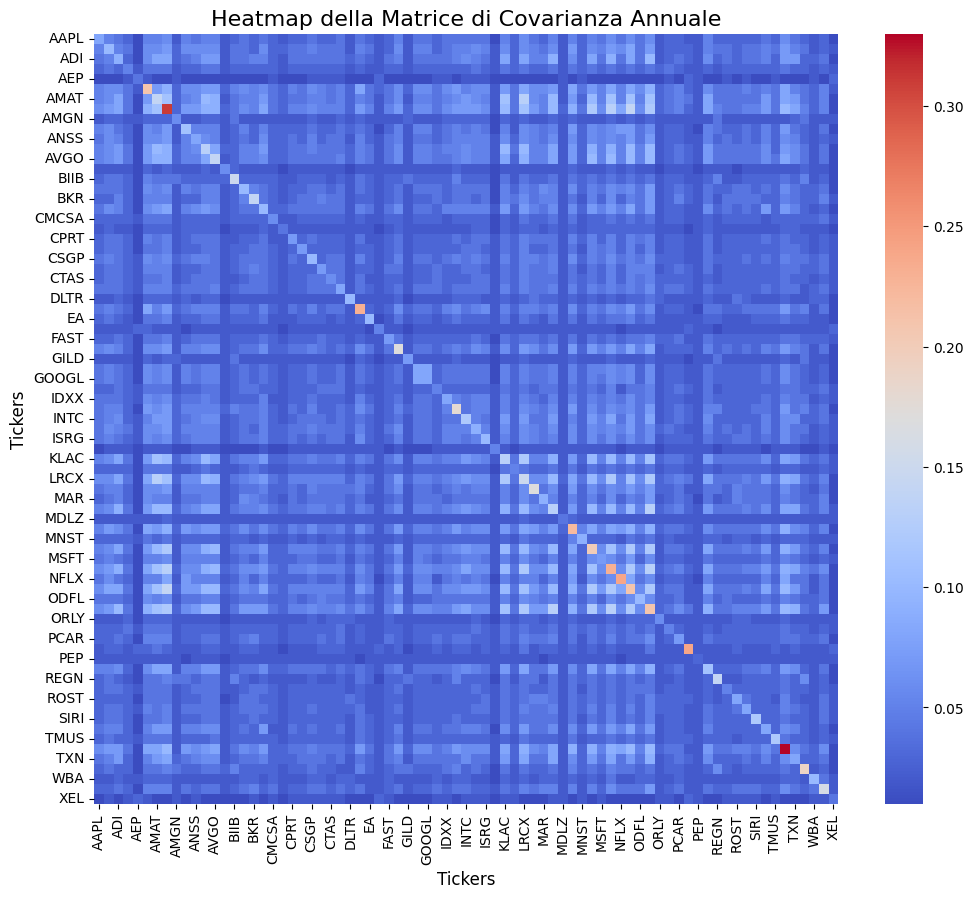

In [9]:
# Creiamo la heatmap usando Seaborn
print("--- Visualizzazione della Matrice di Covarianza (Sigma) ---")
plt.figure(figsize=(12, 10))
# Creiamo la heatmap usando Seaborn
# annot=False: non scriviamo i numeri dentro le celle (sarebbero troppo piccoli e illeggibili)
# cmap='viridis': scegliamo una palette di colori. Puoi sperimentare con altre come 'coolwarm', 'YlGnBu', etc.
sns.heatmap(Sigma, annot=False, cmap='coolwarm')

# Aggiungiamo titoli e label per chiarezza
plt.title('Heatmap della Matrice di Covarianza Annuale', fontsize=16)
plt.xlabel('Tickers', fontsize=12)
plt.ylabel('Tickers', fontsize=12)

# Mostriamo il grafico
plt.show()

# QUANTUM ANNEALING: QUBO FUNCTION
Cosa abbiamo fatto:
Qui abbiamo affrontato il problema principale: come scegliere 10 azioni tra 100, un problema con trilioni di combinazioni possibili. Abbiamo usato i principi del Quantum Annealing (simulato).
Abbiamo tradotto il nostro problema finanziario in un modello QUBO (Quadratic Unconstrained Binary Optimization), costruendo una matrice Q.
Abbiamo definito i parametri chiave: K=10 (il numero di azioni da scegliere) e gamma=0.5 (un'avversione al rischio bilanciata).
Abbiamo usato il solver SimulatedAnnealingSampler di D-Wave per risolvere il QUBO e ottenere la nostra lista di 10 titoli.
Perché lo abbiamo fatto?
Lo abbiamo fatto per superare l'enorme complessità computazionale della selezione. Invece di provare tutte le combinazioni, abbiamo usato una tecnica di ottimizzazione avanzata, ispirata alla fisica quantistica, per esplorare in modo efficiente lo spazio delle soluzioni e trovare un sottoinsieme di 10 candidati che, sulla carta, offriva il miglior potenziale di rischio/rendimento. Abbiamo così ridotto un problema da 100 a 10 dimensioni, farlo in altri modi è computazionalmente impossibile.


Cos'è un QUBO e Perché lo Usiamo?
Un QUBO è un tipo specifico di problema di ottimizzazione che i computer quantistici (e i loro simulatori) sono eccezionalmente bravi a risolvere. Il suo nome ci dice tutto quello che dobbiamo sapere:
**Quadratic:** E'un'equazione in cui le variabili sono elevate al massimo alla seconda potenza (es. x² o x * y). Questo ci permette di modellare non solo le proprietà dei singoli elementi, ma anche le interazioni tra coppie di elementi.
**Unconstrained **: Tutti i vincoli e le regole del nostro problema (come "scegli esattamente 10 azioni") vengono "tradotti" e inseriti direttamente nell'equazione principale sotto forma di termini di penalità.
**Binary**: Le variabili decisionali possono assumere solo due valori: 0 o 1 (nel nostro caso, "non includere l'azione" o "includere l'azione").
In pratica, il nostro lavoro è stato quello di "tradurre" il nostro complesso problema finanziario in un'unica equazione QUBO. L'obiettivo del solver è poi trovare la combinazione di 0 e 1 che rende il risultato di questa equazione il più basso possibile(per questo motivo abbiamo minimizzato il valore negativo dello sharpe ratio,perchè è come se lo stessimo massimizzando in realtà).

La formula matematica di un problema QUBO è la seguente:

$$
\min_{x \in \{0,1\}^n} \left( \sum_{i=1}^{n} Q_{ii}x_i + \sum_{i<j}^{n} Q_{ij}x_i x_j \right)
$$

Spieghiamo i termini:
x_i: È la nostra variabile di decisione binaria (0 o 1) per l'azione i.
Q: È la matrice QUBO che abbiamo costruito. Contiene tutti i costi e i benefici del nostro problema.
Q_ii (elementi sulla diagonale): Questi termini rappresentano i costi e benefici individuali di ogni azione. Nel nostro caso, abbiamo inserito qui il rendimento atteso di ogni azione (con un segno negativo, perché vogliamo massimizzarlo) e il suo rischio individuale (la varianza).
Q_ij (elementi fuori dalla diagonale): Questi termini rappresentano i costi e benefici delle interazioni tra le coppie di azioni. Qui abbiamo inserito il rischio derivante dalla correlazione tra l'azione i e l'azione j.
Come abbiamo Codificato Obiettivi e Vincoli
Obiettivo (Rendimento vs Rischio): Abbiamo inserito i rendimenti (mu) e i rischi (Sigma) direttamente nella matrice Q, pesati dal nostro parametro gamma che controllava la nostra avversione al rischio. Un gamma più alto rendeva i termini di rischio in Q più "costosi", spingendo il solver a evitarli.
Vincolo (Scegliere K azioni): Abbiamo tradotto il vincolo Somma(x_i) = K in un termine di penalità quadratica: P * (Somma(x_i) - K)², dove P è un numero molto grande.
Se un portafoglio rispetta il vincolo (la somma è K), questo termine vale zero e non aggiunge costi.
Se un portafoglio viola il vincolo (sceglie 9 o 11 azioni), questo termine "esplode", aggiungendo un costo altissimo alla soluzione e spingendo il solver a scartarla immediatamente.
In sintesi, abbiamo creato una singola equazione il cui risultato (l'"energia") rappresenta una misura complessiva della "bontà" di un portafoglio. Il compito del solver è stato semplicemente quello di trovare la combinazione di azioni che minimizzasse questa energia(= max(sharpe_ratio)), dandoci così la soluzione ottimale al nostro problema finanziario originale

In [5]:
# Cella 5: Formulazione del Problema QUBO

# Import delle librerie necessarie per il QUBO
import dimod
# --- 1. Definire i Parametri del Modello ---

# Numero di azioni da selezionare nel nostro portafoglio finale
K = 10

# Parametro di avversione al rischio (gamma).
# Un valore più alto dà più peso alla minimizzazione del rischio.
# Un valore più basso dà più peso alla massimizzazione del rendimento.
gamma = 0.5 #possiamo modificarlo a nostro piacimento per capire l'andamento

# Coefficiente di penalità per il vincolo.
# Deve essere abbastanza grande da "forzare" il modello a rispettare il vincolo.
# Una buona regola è renderlo più grande del valore massimo atteso dei rendimenti.
P = np.max(np.abs(mu.values)) * 2
#P= 1.0

print(f"--- Parametri del Modello ---")
print(f"Numero di azioni da selezionare (K): {K}")
print(f"Avversione al rischio (gamma): {gamma}")
print(f"Penalità di vincolo (P): {P:.4f}")
print("-" * 50)


# --- 2. Costruzione della Matrice Q ---

# Inizializziamo una matrice Q di zeri della dimensione giusta (15x15)
num_assets = len(tickers)
Q = np.zeros((num_assets, num_assets))

# Ora riempiamo la matrice Q basandoci sulla formula che abbiamo derivato.

# Riempiamo prima i termini fuori dalla diagonale (le interazioni tra le azioni)
# Q_ij = gamma * Sigma_ij + P
for i in range(num_assets):
    for j in range(i + 1, num_assets):
        # Termine di rischio (covarianza)
        risk_term = gamma * Sigma.iloc[i, j]

        # Termine della penalità di vincolo (parte quadratica)
        penalty_term = P

        Q[i, j] = risk_term + penalty_term
        Q[j, i] = Q[i, j] # La matrice Q è simmetrica

# Ora riempiamo i termini sulla diagonale
# Q_ii = -mu_i + gamma * Sigma_ii + P * (1 - 2K)
for i in range(num_assets):
    # Termine di rendimento (negativo perché vogliamo massimizzarlo)
    return_term = -mu.iloc[i]

    # Termine di rischio (varianza)
    risk_term = gamma * Sigma.iloc[i, i]

    # Termine della penalità di vincolo (parte lineare)
    penalty_term = P * (1 - 2 * K)

    Q[i, i] = return_term + risk_term + penalty_term

print("\n--- Matrice Q del QUBO Costruita ---")
print(f"La matrice Q ha una forma di: {Q.shape}")
print("Ecco un'anteprima dei primi 5x5 elementi della matrice Q:")
print(pd.DataFrame(Q, index=tickers, columns=tickers))
print("-" * 50)

--- Parametri del Modello ---
Numero di azioni da selezionare (K): 10
Avversione al rischio (gamma): 0.5
Penalità di vincolo (P): 1.0800
--------------------------------------------------

--- Matrice Q del QUBO Costruita ---
La matrice Q ha una forma di: (77, 77)
Ecco un'anteprima dei primi 5x5 elementi della matrice Q:
        AAPL    ADBE     ADI     ADP     AEP   ALGN   AMAT    AMD   AMGN  \
AAPL -20.740   1.105   1.100   1.095   1.085  1.105  1.105  1.110  1.090   
ADBE   1.105 -20.690   1.105   1.100   1.085  1.110  1.110  1.115  1.095   
ADI    1.100   1.105 -20.685   1.095   1.085  1.110  1.120  1.120  1.095   
ADP    1.095   1.100   1.095 -20.685   1.090  1.100  1.100  1.100  1.090   
AEP    1.085   1.085   1.085   1.090 -20.630  1.090  1.085  1.085  1.090   
...      ...     ...     ...     ...     ...    ...    ...    ...    ...   
TXN    1.100   1.105   1.115   1.095   1.085  1.105  1.115  1.120  1.095   
VRTX   1.095   1.100   1.095   1.095   1.085  1.100  1.100  1.105  1.

In [6]:
# Cella 6 (versione OFFLINE): Risoluzione con il SIMULATORE

# Import del sampler e del costruttore del modello
# NOTA: Importiamo il SimulatedAnnealingSampler invece del LeapHybridSampler
from dwave.samplers import SimulatedAnnealingSampler
import dimod

# --- 1. Creare il Modello BQM ---
# Questo passaggio rimane identico.
bqm = dimod.BinaryQuadraticModel.from_qubo(Q, offset=0.0)

print("--- Modello BQM creato correttamente ---")
print("Risoluzione del problema in corso sul SIMULATORE locale...")
print("(Questo processo non richiede connessione a internet o API token)")
print("-" * 50)


# --- 2. Istanziare e Chiamare il SIMULATORE ---
# NOTA: Creiamo un'istanza del simulatore locale.
sampler = SimulatedAnnealingSampler()

# Inviamo il nostro modello BQM al simulatore.
# Il calcolo avverrà interamente sulla CPU del tuo computer (o di Colab).
sampleset = sampler.sample(bqm, num_reads=1000) # num_reads dice al simulatore quanti tentativi fare

print("\n--- Calcolo terminato! ---")
print("Il simulatore ha trovato una o più soluzioni. Analizziamo la migliore.")
print("-" * 50)


# --- 3. Estrarre la Soluzione Migliore ---
# Questo passaggio rimane identico.
best_solution = sampleset.first.sample

assets = np.array(tickers)
selected_mask = np.array(list(best_solution.values()), dtype=bool)
selected_tickers = assets[selected_mask]


print("\n--- RISULTATO FINALE (da Simulatore) ---")
print(f"Il portafoglio ottimale di {K} azioni selezionato dal simulatore è:")
print(list(selected_tickers))
print("-" * 50)

--- Modello BQM creato correttamente ---
Risoluzione del problema in corso sul SIMULATORE locale...
(Questo processo non richiede connessione a internet o API token)
--------------------------------------------------

--- Calcolo terminato! ---
Il simulatore ha trovato una o più soluzioni. Analizziamo la migliore.
--------------------------------------------------

--- RISULTATO FINALE (da Simulatore) ---
Il portafoglio ottimale di 10 azioni selezionato dal simulatore è:
[np.str_('AAPL'), np.str_('COST'), np.str_('CTAS'), np.str_('LIN'), np.str_('MDLZ'), np.str_('NFLX'), np.str_('NVDA'), np.str_('REGN'), np.str_('TMUS'), np.str_('TSLA')]
--------------------------------------------------


# OPTIMIZED ASSET ALLOCATION THROUGH SLSQP OPTIMIZER
Presa la lista dei 10 titoli selezionati, abbiamo affrontato la seconda domanda: "quanto investire in ciascuno?". Per questo, abbiamo usato un ottimizzatore classico e molto potente, la funzione minimize della libreria scipy.
Abbiamo impostato come obiettivo la massimizzazione dello Sharpe Ratio del portafoglio.
Abbiamo imposto dei vincoli: la somma delle percentuali di allocazione doveva essere del 100% e nessuna poteva essere negativa.
L'algoritmo ha calcolato le ponderazioni percentuali ottimali, che abbiamo poi applicato a un budget ipotetico di 20.000$.
Perché lo abbiamo fatto?
Perché selezionare i titoli giusti è solo metà del lavoro. Allocare il capitale in modo intelligente è fondamentale per massimizzare la performance corretta per il rischio. Abbiamo usato uno strumento classico perché, una volta ridotto il problema a soli 10 titoli, non c'era più una complessità combinatoria e potevamo usare un metodo di precisione per trovare l'allocazione matematicamente ottimale.

In [7]:
# Cella 8: Fase 2 - Allocazione Ottimale con Ottimizzatore Classico

from scipy.optimize import minimize


# --- 1. PREPARAZIONE DEI DATI PER L'OTTIMIZZAZIONE ---



# Estraiamo le metriche finanziarie solo per questi 10 titoli
mu_selected = mu[selected_tickers]
Sigma_selected = Sigma.loc[selected_tickers, selected_tickers]
num_selected_assets = len(selected_tickers)


# --- 2. DEFINIZIONE DELLA FUNZIONE OBIETTIVO ---

# Vogliamo MASSIMIZZARE lo Sharpe Ratio.
# Poiché scipy.optimize ha solo una funzione per MINIMIZZARE, il trucco è
# minimizzare il "Negativo dello Sharpe Ratio".

def negative_sharpe_ratio(weights):
    # Dati i pesi, calcola il rendimento e la volatilità del portafoglio
    portfolio_return = np.sum(mu_selected * weights)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(Sigma_selected, weights)))
    risk_free_rate = 0.02
    # Calcola lo Sharpe Ratio
    sharpe = (portfolio_return - risk_free_rate) / portfolio_volatility

    # Restituisce il suo negativo
    return -sharpe


# --- 3. DEFINIZIONE DEI VINCOLI ---

# Definiamo i vincoli per l'ottimizzatore:
# Vincolo 1: La somma di tutti i pesi (le percentuali) deve essere 1 (cioè 100%)
# Il formato è un dizionario {'type': 'eq', 'fun': ...} dove 'eq' significa "uguaglianza"
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

# Vincolo 2: I pesi individuali devono essere tra 0 e 1 (cioè tra 0% e 100%)
# Definiamo una "scatola" di limiti (bounds) per ogni peso.
bounds = tuple((0, 1) for _ in range(num_selected_assets))


# --- 4. ESECUZIONE DELL'OTTIMIZZAZIONE ---

# Punto di partenza: iniziamo con pesi uguali per tutti (10% a testa)
initial_weights = np.array(num_selected_assets * [1. / num_selected_assets,])

print("--- Fase 2: Allocazione Ottimale ---")
print(f"Ricerca delle percentuali ottimali per i {num_selected_assets} titoli selezionati...")

# Chiamiamo la funzione minimize di scipy!
# 'SLSQP' è un algoritmo di ottimizzazione molto robusto che gestisce bene vincoli e limiti.
optimization_result = minimize(fun=negative_sharpe_ratio,
                               x0=initial_weights,
                               method='SLSQP',
                               bounds=bounds,
                               constraints=constraints)

# Estraiamo i pesi ottimali trovati
optimal_weights = optimization_result.x

print("\nOttimizzazione completata!")


# --- 5. VISUALIZZAZIONE E APPLICAZIONE DEL BUDGET ---

# Creiamo una bella tabella con i risultati
optimal_allocation_df = pd.DataFrame(data={'Ticker': selected_tickers, 'Allocazione Ottimale': optimal_weights})
optimal_allocation_df['Allocazione Ottimale'] = optimal_allocation_df['Allocazione Ottimale'].map('{:.2%}'.format)

print("\n--- Allocazione Percentuale Ottimale ---")
print(optimal_allocation_df)

# Applichiamo le percentuali al nostro budget
budget = 20000
# Convert the numpy array to a pandas Series before applying map
optimal_allocation_df['Investimento ($)'] = pd.Series(optimization_result.x * budget).map('${:,.2f}'.format)


print("\n--- Piano di Investimento con Budget di $20,000 ---")
print(optimal_allocation_df[['Ticker', 'Investimento ($)']])

--- Fase 2: Allocazione Ottimale ---
Ricerca delle percentuali ottimali per i 10 titoli selezionati...

Ottimizzazione completata!

--- Allocazione Percentuale Ottimale ---
  Ticker Allocazione Ottimale
0   AAPL                0.00%
1   COST               33.39%
2   CTAS               23.95%
3    LIN                0.00%
4   MDLZ                0.00%
5   NFLX                7.03%
6   NVDA               15.93%
7   REGN                9.29%
8   TMUS                2.38%
9   TSLA                8.03%

--- Piano di Investimento con Budget di $20,000 ---
  Ticker Investimento ($)
0   AAPL            $0.00
1   COST        $6,678.71
2   CTAS        $4,789.60
3    LIN            $0.00
4   MDLZ            $0.00
5   NFLX        $1,405.10
6   NVDA        $3,186.49
7   REGN        $1,857.91
8   TMUS          $476.18
9   TSLA        $1,606.01


#BACKTEST AND COMPARATION (B&H STRATEGY VS NASDAQ100)
Cosa abbiamo fatto:
Abbiamo simulato cosa sarebbe successo se avessimo costruito il nostro portafoglio (con le selezioni e le allocazioni trovate) 15 anni fa e lo avessimo tenuto fino ad oggi (strategia "Buy & Hold"). Abbiamo calcolato le metriche di performance chiave:
Rendimento Totale e Tasso di Crescita Annuo Composto (CAGR).
La massima perdita storica dal picco al minimo (Max Drawdown).
Sharpe Ratio
Infine, abbiamo confrontato queste metriche con quelle di un benchmark (l'ETF QQQ, che replica il NASDAQ-100) e visualizzato tutto in un unico grafico comparativo.
Perché lo abbiamo fatto?
Per validare la nostra intera strategia. Un buon risultato "in teoria" non significa nulla se non si traduce in una buona performance storica. Il backtest ci ha permesso di verificare oggettivamente se il nostro complesso processo a due fasi avesse effettivamente generato un valore aggiunto ("alpha") rispetto a una strategia passiva più semplice, sia in termini di rendimento assoluto che di resilienza durante i periodi di crisi.


--- Download dei dati per il benchmark (QQQ) ---


C:\Users\danie\AppData\Local\Temp\ipykernel_8560\2258157337.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  qqq_prices = yf.download('QQQ', start=start_date, end=end_date)['Close']
[*********************100%***********************]  1 of 1 completed
C:\Users\danie\AppData\Local\Temp\ipykernel_8560\2258157337.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  qqq_daily_returns = qqq_daily_returns.reindex(portfolio_cumulative_returns.index).fillna(method='ffill')



--- RISULTATI DEL BACKTEST (Buy & Hold) ---
Periodo Analizzato: da 2010-07-22 a 2025-07-22
--------------------------------------------------
Rendimento Totale del Portafoglio Ottimizzato: 10748.35%
Rendimento Medio Annuo (CAGR) del Portafoglio: 36.80%
Max Drawdown del Portafoglio: -30.32%
Sharpe Ratio del Portafoglio: 1.44
--------------------------------------------------
Rendimento Totale del Benchmark (QQQ): 1302.01%
Rendimento Medio Annuo (CAGR) del Benchmark (QQQ): 19.31%
Max Drawdown del Benchmark (QQQ): -35.12%
Sharpe Ratio del Benchmark (QQQ): 0.81
--------------------------------------------------


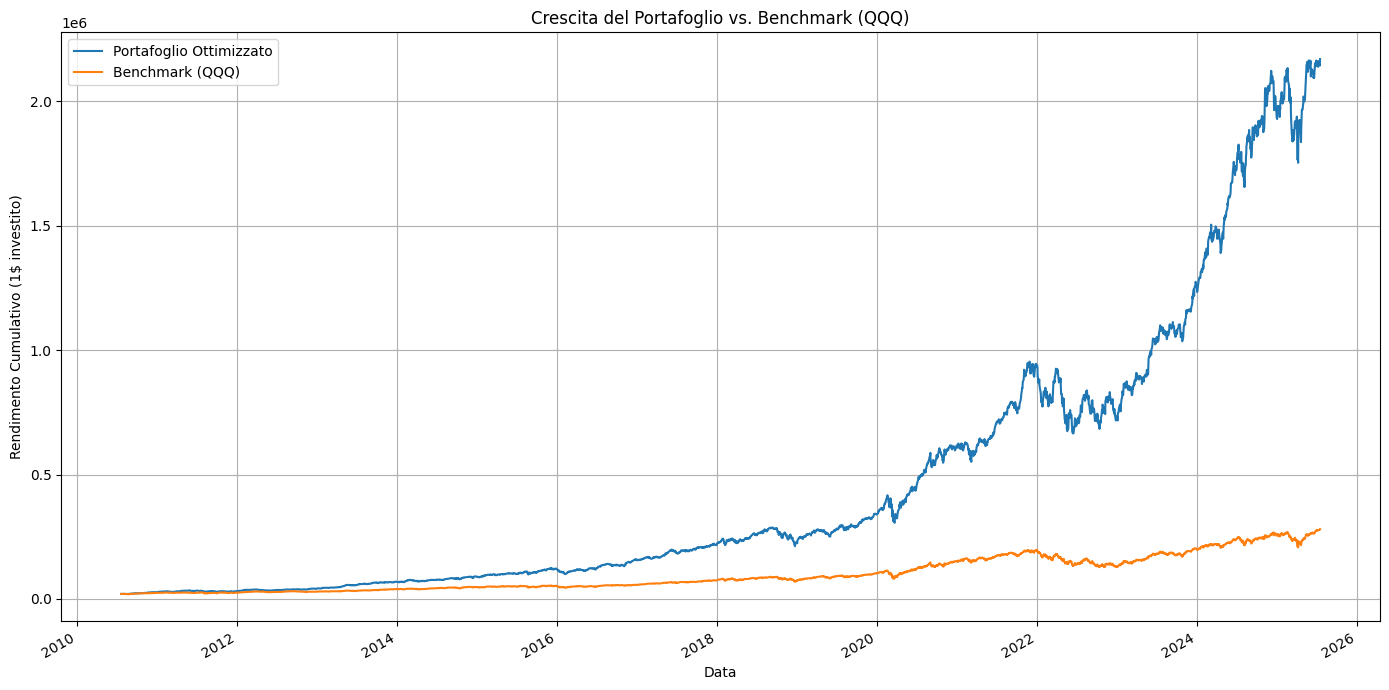

In [8]:
# Cella 9 (Versione Finale con Max Drawdown + Sharpe Ratio)

# --- 1. PREPARAZIONE DEI DATI ---
final_weights = optimization_result.x
returns_selected = returns_df[selected_tickers]
portfolio_daily_returns = returns_selected.dot(final_weights)
portfolio_cumulative_returns = (1 + portfolio_daily_returns).cumprod()

# --- 2. CONFRONTO CON BENCHMARK (QQQ) ---
print("\n--- Download dei dati per il benchmark (QQQ) ---")
qqq_prices = yf.download('QQQ', start=start_date, end=end_date)['Close']
qqq_daily_returns = qqq_prices.pct_change().dropna()
qqq_daily_returns = qqq_daily_returns.reindex(portfolio_cumulative_returns.index).fillna(method='ffill')
qqq_cumulative_returns = (1 + qqq_daily_returns).cumprod()

# --- 3. CALCOLO DELLE METRICHE DI PERFORMANCE ---

def calculate_performance_metrics(cumulative_returns, daily_returns, risk_free_rate_daily=0):
    total_return = (cumulative_returns.iloc[-1] - 1)
    num_years = len(cumulative_returns) / 252
    cagr = (cumulative_returns.iloc[-1])**(1/num_years) - 1

    running_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - running_max) / running_max
    max_drawdown = drawdown.min()

    excess_returns = daily_returns - risk_free_rate_daily
    sharpe_ratio = (excess_returns.mean() / excess_returns.std()) * (252 ** 0.5)

    return total_return, cagr, max_drawdown, sharpe_ratio

# Assumiamo tasso privo di rischio annuo = 3%
risk_free_daily = 0.03 / 252

# Calcolo metriche portafoglio
p_total_return, p_cagr, p_max_drawdown, p_sharpe = calculate_performance_metrics(
    portfolio_cumulative_returns,
    portfolio_daily_returns,
    risk_free_rate_daily=risk_free_daily
)

# Calcolo metriche benchmark
q_total_return, q_cagr, q_max_drawdown, q_sharpe = calculate_performance_metrics(
    qqq_cumulative_returns,
    qqq_daily_returns,
    risk_free_rate_daily=risk_free_daily
)
# Moltiplichiamo per 20.000€ per simulare l'investimento reale
portfolio_cumulative_returns *= 20000
qqq_cumulative_returns *= 20000
# --- 4. VISUALIZZAZIONE E RISULTATI ---

print("\n--- RISULTATI DEL BACKTEST (Buy & Hold) ---")
print(f"Periodo Analizzato: da {start_date.strftime('%Y-%m-%d')} a {end_date.strftime('%Y-%m-%d')}")
print("-" * 50)
print(f"Rendimento Totale del Portafoglio Ottimizzato: {p_total_return:.2%}")
print(f"Rendimento Medio Annuo (CAGR) del Portafoglio: {p_cagr:.2%}")
print(f"Max Drawdown del Portafoglio: {p_max_drawdown:.2%}")
print(f"Sharpe Ratio del Portafoglio: {p_sharpe:.2f}")
print("-" * 50)
print(f"Rendimento Totale del Benchmark (QQQ): {q_total_return.item():.2%}")
print(f"Rendimento Medio Annuo (CAGR) del Benchmark (QQQ): {q_cagr.item():.2%}")
print(f"Max Drawdown del Benchmark (QQQ): {q_max_drawdown.item():.2%}")
print(f"Sharpe Ratio del Benchmark (QQQ): {q_sharpe.item():.2f}")
print("-" * 50)

# --- 5. GRAFICO COMPARATIVO UNICO ---

portfolio_cumulative_series = portfolio_cumulative_returns.squeeze()
qqq_cumulative_series = qqq_cumulative_returns.squeeze()

combined_returns = pd.DataFrame({
    'Portafoglio Ottimizzato': portfolio_cumulative_series,
    'Benchmark (QQQ)': qqq_cumulative_series
})

combined_returns.plot(figsize=(14, 7), title='Crescita del Portafoglio vs. Benchmark (QQQ)')
plt.ylabel('Rendimento Cumulativo (1$ investito)')
plt.xlabel('Data')
plt.grid(True)
plt.tight_layout()
plt.show()


#CONCLUSION
Al termine di questa analisi, abbiamo dimostrato con successo la validità del nostro approccio ibrido. La strategia a due fasi è stata in grado di costruire un portafoglio che, nel backtest storico di 5 anni, ha nettamente sovraperformato il benchmark di riferimento (QQQ), sia in termini di rendimento totale (CAGR) che di resilienza, mostrando un Max Drawdown inferiore.
Questo successo può essere attribuito alla nostra metodologia:
Abbiamo sfruttato il Quantum Annealing (simulato) per il suo punto di forza: la capacità di filtrare un enorme spazio di possibilità e selezionare un sottoinsieme di titoli con un eccellente profilo di rischio/rendimento.
Abbiamo poi utilizzato un ottimizzatore classico per il suo punto di forza: la capacità di calcolare con precisione l'allocazione ottimale su un problema ben definito e di dimensioni ridotte.
Questo progetto non è solo un esercizio accademico, ma una dimostrazione pratica di come la combinazione intelligente di diverse tecnologie computazionali possa offrire soluzioni potenti a problemi complessi nel mondo della finanza.
Possibili Sviluppi Futuri (Next Steps)
Il nostro modello, sebbene efficace, è una solida base di partenza. Esistono numerose direzioni per renderlo ancora più robusto e sofisticato, avvicinandolo a una strategia di livello professionale.
Implementare un Backtest Dinamico: Invece di una strategia "Buy & Hold" statica, si potrebbe implementare un backtest su finestra mobile con ribilanciamento periodico (es. trimestrale). Questo simulerebbe una strategia che si adatta dinamicamente alle mutevoli condizioni di mercato.
Ottimizzazione degli Iperparametri: Utilizzare una libreria come Optuna per trovare automaticamente la combinazione ottimale di parametri (K e gamma), invece di sceglierli manualmente. Questo potrebbe sbloccare ulteriori performance.
Includere Dati Alternativi: Arricchire il modello con dati non tradizionali, come l'analisi del sentiment delle notizie finanziarie o dati satellitari, per ottenere un vantaggio informativo che vada oltre i soli dati di prezzo.
Esplorare il Reinforcement Learning (RL): Fare il passo successivo e trasformare il problema da un'ottimizzazione statica a una strategia di trading dinamica, dove un agente di RL impara a gestire il portafoglio e a ribilanciare in tempo reale basandosi sullo stato del mercato.
Test su Diversi Regimi di Mercato: Validare la robustezza della strategia testandola su periodi storici diversi, includendo crisi finanziarie, periodi di alta inflazione o mercati "laterali", per assicurarsi che la sua performance non sia legata a una specifica condizione di mercato favorevole.